# MNIST Quickshift Node Removal

In [1]:
import sys, os
sys.path.insert(0, '..')

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import numpy as np
from skimage import color, draw
from skimage.future import graph

def _scale(image, scale=8):
    if scale == 1:
        return image
    else:
        image = np.repeat(image, scale, axis=0)
        image = np.repeat(image, scale, axis=1)
        return image

def draw_rag(image, segmentation):
    image = color.gray2rgb(np.reshape(image, (28, 28)))
    image = _scale(image)
    segmentation = _scale(segmentation)
    
    rag = graph.rag_mean_color(image, segmentation)
    graph.draw_rag(segmentation, rag, image)  # Calculate the centroids internally.
    
    out_1 = image.copy()
    
    for n1, n2, data in rag.edges_iter(data=True):
        r1, c1 = map(int, rag.node[n1]['centroid'])
        r2, c2 = map(int, rag.node[n2]['centroid'])
        line = draw.line(r1, c1, r2, c2)
        out_1[line] = [1, 0, 0]
        
    for n, d in rag.nodes_iter(data=True):
        r, c = map(int, rag.node[n]['centroid'])
        if r > 1 and c > 1 and r < image.shape[0] - 1 and c < image.shape[1] - 1:
            circle = draw.circle(r, c, 2)
            out_1[circle] = [0, 1, 0]
            
    out_2 = image.copy()
    
    for n1, n2, data in rag.edges_iter(data=True):
        mean_1 = rag.node[n1]['mean color'][0]
        mean_2 = rag.node[n2]['mean color'][0]
        if mean_1 < 0.01 or mean_2 < 0.01:
            continue
        
        r1, c1 = map(int, rag.node[n1]['centroid'])
        r2, c2 = map(int, rag.node[n2]['centroid'])
        line = draw.line(r1, c1, r2, c2)
        out_2[line] = [1, 0, 0]
        
    for n, d in rag.nodes_iter(data=True):
        mean = rag.node[n]['mean color'][0]
        if mean < 0.01:
            continue
        
        r, c = map(int, rag.node[n]['centroid'])
        if r > 1 and c > 1 and r < image.shape[0] - 1 and c < image.shape[1] - 1:
            circle = draw.circle(r, c, 2)
            out_2[circle] = [0, 1, 0]
     
    plt.rcParams['figure.figsize'] = (10, 5)
    fig = plt.figure()
    fig.add_subplot(121)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(out_1)
    fig.add_subplot(122)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(out_2)
    
    plt.show()

## Load dataset

In [3]:
from lib.datasets import MNIST

mnist = MNIST('../data/mnist').test
images, _ = mnist.next_batch(3, shuffle=False)

image_1 = images[0]
image_2 = images[1]
image_3 = images[2]

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
from lib.segmentation import quickshift

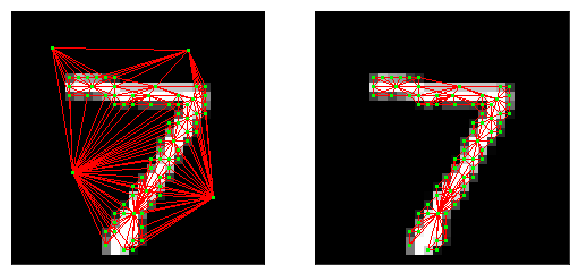

In [5]:
image = images[0]
segmentation = quickshift(image, ratio=1, kernel_size=2, max_dist=2, sigma=0)
draw_rag(image, segmentation)

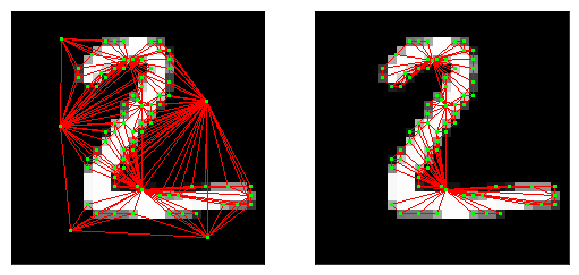

In [6]:
image = images[1]
segmentation = quickshift(image, ratio=1, kernel_size=2, max_dist=2, sigma=0)
draw_rag(image, segmentation)

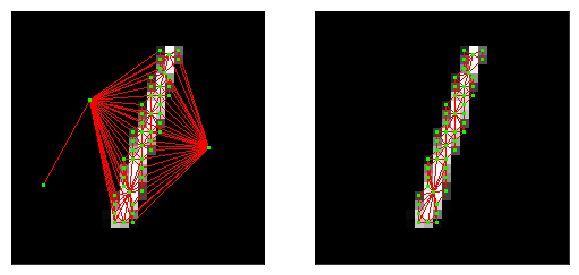

In [7]:
image = images[2]
segmentation = quickshift(image, ratio=1, kernel_size=2, max_dist=2, sigma=0)
draw_rag(image, segmentation)

## Validate different node removal algorithms

**Important:** The graph should still be fully-connected after node removal.

In [8]:
import scipy.sparse as sp

from lib.graph import filter_adj
from lib.segmentation import segmentation_adjacency, extract_features

def _validate_adj(adj):
    adj.data = adj.data.astype(np.float32)
    lap = sp.csgraph.laplacian(adj, normed=True)
    
    # Check that lambda_1 > 0, so that adj is connected.
    lambdas, _ = np.linalg.eig(lap.toarray())
    lambdas = np.sort(lambdas)
    lambda_1 = lambdas[1]
    lambda_1 = round(lambda_1, 8)
    return lambda_1 > 0

def node_removal(images, algorithm):
    valids = []
    removed = []
    
    for image in images:
        segmentation = quickshift(image, ratio=1, kernel_size=2, max_dist=2, sigma=0)
        adj, _, _ = segmentation_adjacency(segmentation)
        features = extract_features(segmentation, image, [0])
        nodes = algorithm(adj, features)
        adj_new = filter_adj(adj, nodes)
        valid = _validate_adj(adj_new)
        
        removed.append(adj.shape[0] - adj_new.shape[0])
        valids.append(valid)
    
    valids = np.array(valids, dtype=np.uint8)
    valid = valids.mean()
    print('Valid adjacencies: {:.2f}%'.format(valid * 100))
    removed = np.array(removed, dtype=np.float32)
    removed = removed.mean()
    print('Mean nodes removed: {:.2f}'.format(removed))

In [9]:
images, _ = mnist.next_batch(1000, shuffle=False)

### Color threshold

In [10]:
from lib.graph import gray_color_threshold_fixed

gray_color_threshold = gray_color_threshold_fixed(0.01)
node_removal(images, gray_color_threshold)

Valid adjacencies: 99.90%
Mean nodes removed: 4.97


### Degree threshold

In [11]:
from lib.graph import degree_threshold_fixed

degree_threshold = degree_threshold_fixed(15)
node_removal(images, degree_threshold)

Valid adjacencies: 45.70%
Mean nodes removed: 3.19
